In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import enum
import numpy as np
from esda.moran import Moran
from libpysal.weights import KNN

import scipy.stats

In [10]:
class CellType(enum.IntEnum):
    HSC = 0
    MPP1 = 1
    MPP2 = 2
    MPP3 = 3
    MPP4 = 4
    MPP5 = 5
    CMP = 6
    CLP = 7
    MEP = 8
    GMP = 9
    Erythroblast1 = 10
    Erythroblast2 = 11
    Erythroblast3 = 12
    Erythroblast4 = 13
    Erythroblast5 = 14
    Erythroblast6 = 15
    Erythroblast7 = 16
    Erythroblast8 = 17
    RBC = 18
    Myeloblast1 = 19
    Myeloblast2 = 20
    Myeloblast3 = 21
    Myeloblast4 = 22
    Myeloblast5 = 23
    Myeloblast6 = 24
    Myeloblast7 = 25
    Myeloid = 26
    Megakaryocyte = 27
    Platelet = 28
    Lymphocyte1 = 29
    Lymphocyte2 = 30
    Lymphocyte3 = 31
    Lymphocyte4 = 32
    Lymphocyte5 = 33
    Lymphocyte6 = 34
    Lymphocyte7 = 35
    Lymphocyte8 = 36
    Lymphocyte9 = 37
    Lymphocyte10 = 38
    Bcell = 39
    STROMA = 40

HSC = [CellType.HSC] 
MPP = [CellType.MPP1, CellType.MPP2, CellType.MPP3, CellType.MPP4, CellType.MPP5]
RPP = [CellType.CMP, CellType.CLP, CellType.MEP, CellType.GMP]
HSPC = HSC + MPP + RPP

ERYTHRO = [CellType.Erythroblast1, CellType.Erythroblast2, CellType.Erythroblast3, CellType.Erythroblast4, CellType.Erythroblast5, CellType.Erythroblast6, CellType.Erythroblast7, CellType.Erythroblast8, CellType.RBC]
MYELO = [CellType.Myeloblast1, CellType.Myeloblast2, CellType.Myeloblast3, CellType.Myeloblast4, CellType.Myeloblast5, CellType.Myeloblast6, CellType.Myeloblast7, CellType.Myeloid]
LYMPH = [CellType.Lymphocyte1, CellType.Lymphocyte2, CellType.Lymphocyte3, CellType.Lymphocyte4, CellType.Lymphocyte5, CellType.Lymphocyte6, CellType.Lymphocyte7, CellType.Lymphocyte8, CellType.Lymphocyte9, CellType.Lymphocyte10, CellType.Bcell]
PLAT = [CellType.Megakaryocyte, CellType.Platelet]

In [3]:
df = pd.read_csv('../data/test_all_steps.csv')
df.head()

,step,cell_type,x,y,dx,dy,clone_id,vessel_neighbourhood,status,cell_id
0,0,39,141.0577,175.8942,0.0,0.0,-1,0,0,0
1,0,39,332.0818,360.5800,0.0,0.0,-1,0,0,1
2,0,39,321.1145,152.8243,0.0,0.0,-1,0,0,2
3,0,39,391.8012,300.3834,0.0,0.0,-1,0,0,3
4,0,39,288.0393,225.3183,0.0,0.0,-1,0,0,4


In [32]:
def get_group(cell_type: CellType):
    if cell_type in HSPC:
        return 'HSPC'
    elif cell_type in MYELO:
        return 'MYELO'
    elif cell_type in LYMPH:
        return 'LYMPH'
    elif cell_type in ERYTHRO:
        return 'ERYTHRO'
    return 'Other' 


def get_step_data(step: int):
    d = df[df.step == step].copy()
    d['group'] = d['cell_type'].apply(get_group)
    return d

step_data = get_step_data(df.step.max())
step_data[step_data['group'] == 'HSPC']

,step,cell_type,x,y,dx,dy,clone_id,vessel_neighbourhood,status,cell_id,group
10328054,4000,0,136.5300,207.4003,0.1084,-0.1122,21,0,0,2556,HSPC
10328259,4000,6,148.1286,441.4872,0.1991,0.1283,17,0,0,3618,HSPC
10328337,4000,5,181.5746,376.5151,0.0079,-0.1147,18,1,0,4660,HSPC
10328363,4000,5,191.5521,409.3130,0.0441,-0.0381,18,0,0,4941,HSPC
10328373,4000,5,414.5110,4.0000,0.0463,-0.0886,20,0,0,5088,HSPC
...,...,...,...,...,...,...,...,...,...,...,...
10330274,4000,9,462.8645,229.5804,-0.0725,0.0487,19,0,0,13846,HSPC
10330475,4000,9,74.9102,394.6792,-0.0443,0.1389,21,0,0,14132,HSPC
10330496,4000,6,72.7269,385.8748,0.1134,0.0292,21,0,0,14159,HSPC
10330499,4000,6,77.1198,402.3517,-0.1436,-0.0640,21,0,0,14162,HSPC


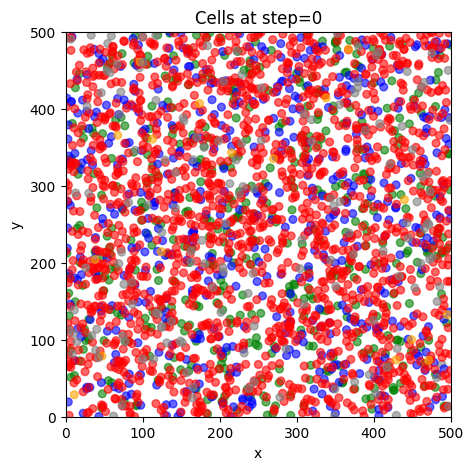

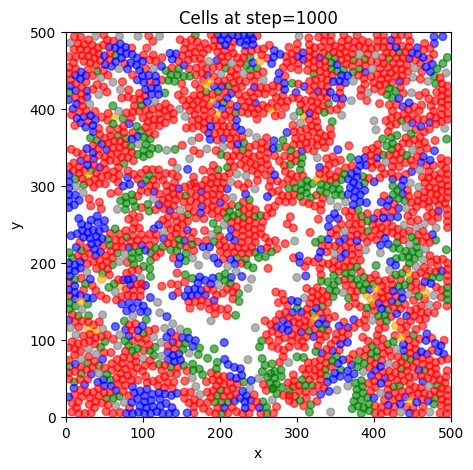

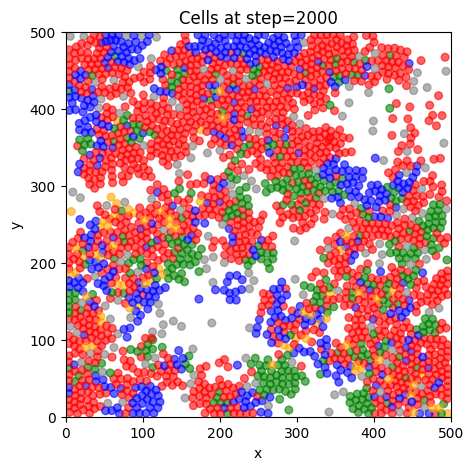

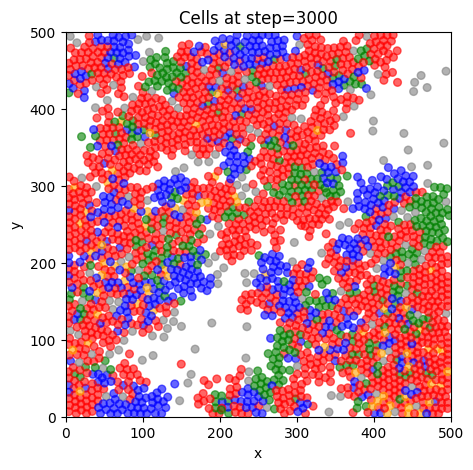

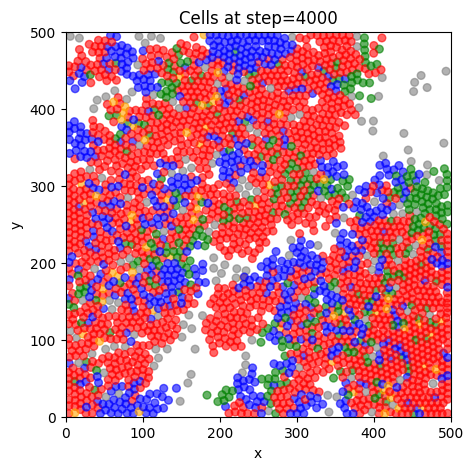

In [35]:
colors = {'HSPC': 'orange', 'ERYTHRO': 'red', 'LYMPH': 'green', 'MYELO': 'blue', 'Other': 'gray'}

def plot_cells(step_data: pd.DataFrame):
    plt.figure(figsize=(5, 5), dpi=100)
    ax = plt.gca()
    for _, row in step_data.iterrows():
        color = colors[row['group']]
        circle = plt.Circle((row['x'], row['y']), 5, color=color, alpha=0.6)
        ax.add_patch(circle)

    ax.set_xlim(0, 500)
    ax.set_ylim(0, 500)
    ax.set_aspect('equal')
    plt.title(f'Cells at step={step_data.step.values[0]}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

plot_cells(get_step_data(0))
plot_cells(get_step_data(1000))
plot_cells(get_step_data(2000))
plot_cells(get_step_data(3000))

In [72]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
step_data = get_step_data(0)
k = 5

positions = step_data[["x", "y"]].values
groups = step_data["group"].values

# Encode the group labels as integers
le = LabelEncoder()
group_encoded = le.fit_transform(groups)

nbrs = NearestNeighbors(n_neighbors=k+1).fit(positions)
distances, indices = nbrs.kneighbors(positions)

predicted_labels = []

for i, neighbors in enumerate(indices):
    neighbor_labels = group_encoded[neighbors[1:]]
    pred = scipy.stats.mode(neighbor_labels, keepdims=True).mode[0]
    predicted_labels.append(pred)

step_data['knn_predicted_group'] = predicted_labels
step_data

,step,cell_type,x,y,dx,dy,clone_id,vessel_neighbourhood,status,cell_id,group,knn_predicted_group
0,0,39,141.0577,175.8942,0.0,0.0,-1,0,0,0,LYMPH,0
1,0,39,332.0818,360.5800,0.0,0.0,-1,0,0,1,LYMPH,0
2,0,39,321.1145,152.8243,0.0,0.0,-1,0,0,2,LYMPH,0
3,0,39,391.8012,300.3834,0.0,0.0,-1,0,0,3,LYMPH,0
4,0,39,288.0393,225.3183,0.0,0.0,-1,0,0,4,LYMPH,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2702,0,40,75.7084,171.9686,0.0,0.0,-1,0,0,2702,Other,0
2703,0,40,165.4300,333.8188,0.0,0.0,-1,0,0,2703,Other,2
2704,0,40,430.5607,88.4805,0.0,0.0,-1,0,0,2704,Other,2
2705,0,40,278.1971,25.3086,0.0,0.0,-1,0,0,2705,Other,0


Adjusted Rand Index: -0.020
F1 Score: 0.432


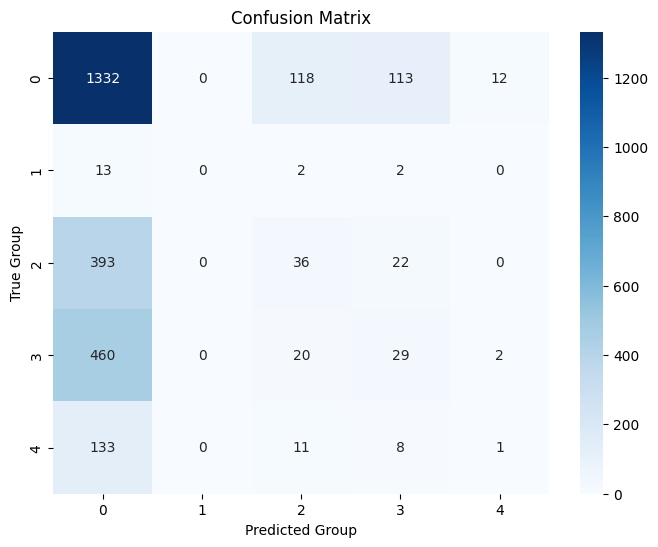

In [73]:
from sklearn.metrics import adjusted_rand_score, f1_score, confusion_matrix

# Adjusted Rand Index
ari = adjusted_rand_score(step_data['group'],step_data['knn_predicted_group'])
print(f"Adjusted Rand Index: {ari:.3f}")


y_true = group_encoded
y_pred = step_data['knn_predicted_group'].values

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.3f}")

cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_true),
            yticklabels=np.unique(y_true))
plt.xlabel('Predicted Group')
plt.ylabel('True Group')
plt.title('Confusion Matrix')
plt.show()


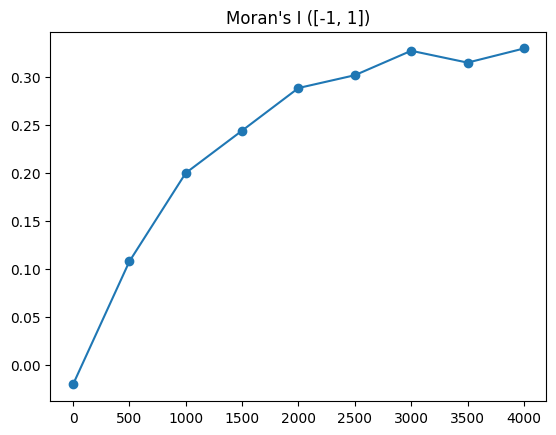

In [92]:

morans_i = []
xr = list(range(0, 4001, 500))
for i in xr:
    step_data = get_step_data(i)
    
    k = 5
    positions = step_data[["x", "y"]].values
    groups = LabelEncoder().fit_transform(step_data['group'])

    w = KNN.from_array(positions, k=k)
    w.transform = 'r'  # Row-standardize weights

    mi = Moran(groups, w)
    
    if mi.p_sim > 0.05:
        print(f'Step {i}')
        print(f"Moran's I: {mi.I:.3f}")
        print(f"p-value: {mi.p_sim:.3f}")
    morans_i.append(mi.I)

plt.plot(xr, morans_i, '-o')
plt.title("Moran's I")
plt.show()